# <a id='toc1_'></a>[T23 State Space Control - Part 5](#toc0_)

**Table of contents**<a id='toc0_'></a>    
- [T23 State Space Control - Part 5](#toc1_)    
  - [LQR Servo -- Topic 27](#toc1_1_)    
- [DOFB Servo](#toc2_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [ ]:
import requests as req, os

URL = "https://raw.githubusercontent.com/mit-acl/16_06_Class/main/"
File = ["basic_material.py","control_materials.py"]

if not os.path.isfile(File[0]):
    print('Basic files not` found - downloading it')
    for dfile in File:
        if not os.path.isfile(dfile):
            print(dfile)
            res = req.get(URL+dfile)
            file = open(dfile, 'w')
            file.write(res.text)
            file.close()
else:
    print('Basic file found')
from basic_material import *

j = complex(0,1)

from scipy.optimize import minimize
from scipy.signal import butter,bessel
from control.matlab import tf, ss, ss2tf, step, place, rlocus, lqr, lsim, ssdata
from control_materials import *

Basic file found
Running Python: 3.12.8
Running Sympy: 1.13.3
Control Package Found
This is a library of basic functions for 16.06
This is a library of useful functions for the control systems in 16.06


## <a id='toc1_1_'></a>[LQR Servo -- Topic 27](#toc0_)

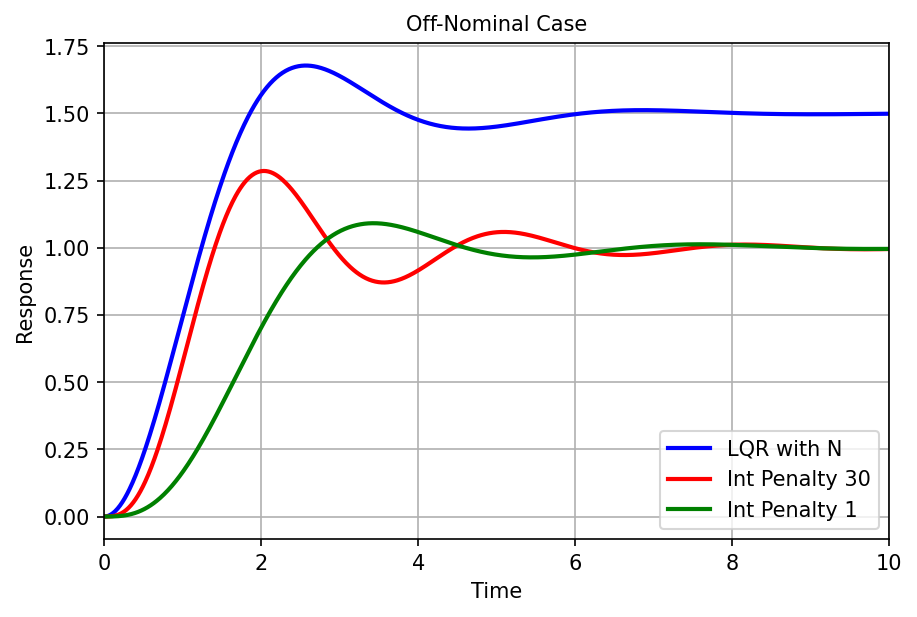

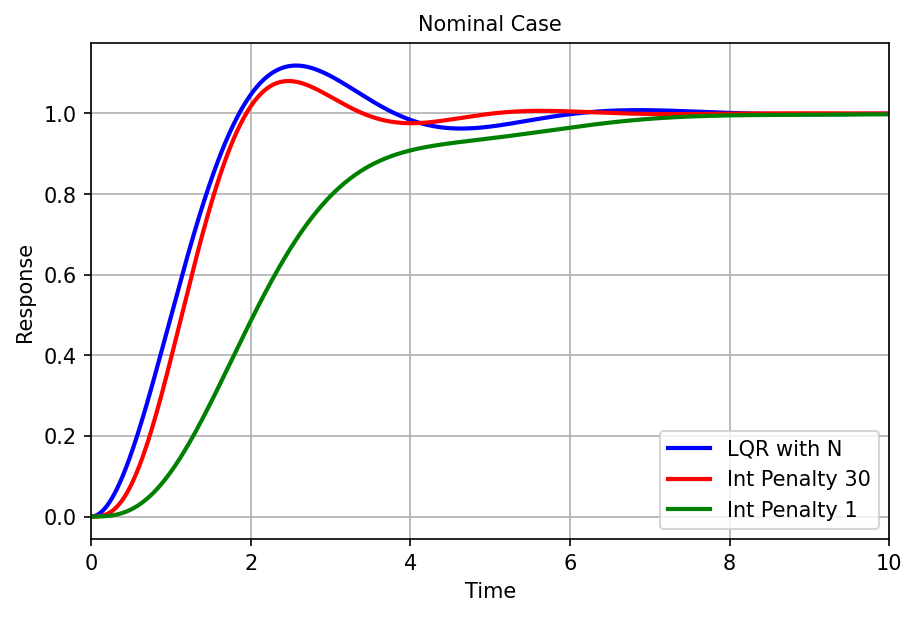

In [2]:
G=tf([1, 2],np.convolve([1, -1],[1, -1, 2]))
a,b,c,d = ssdata(G)

def LQRservo(nom = 1):
    # consider possibility that c is wrong in the design
    # use c in design of K's and N's, but simulate with cpert
    if nom:
        cpert = c # nominal case
    else:
        cpert = 1.5*c # off-nominal case

    ns = np.shape(a)[0]
    z = np.zeros((ns,1));
    Rxx = c.transpose()@c
    Ruu = 1

    klqr,_,_ = lqr(a,b,Rxx,Ruu); # basic LQR gains
    klqr = np.asarray(klqr)
    Nbar = np.linalg.inv(np.dot(-c,np.dot(np.linalg.inv(a-b*klqr),b))); # design with c
    syslqr=ss(a-b*klqr,b*Nbar,cpert,0); # simulate with cpert

    Rxx1 = np.vstack((np.hstack((Rxx,np.zeros((ns,1)))),\
                      np.hstack((np.zeros((1,ns)),np.array([30]).reshape(1,1)))))
    Rxx2 = np.vstack((np.hstack((Rxx,np.zeros((ns,1)))),\
                      np.hstack((np.zeros((1,ns)),np.array([1]).reshape(1,1)))))

    # design with c
    abar = np.vstack((np.hstack((a,np.zeros((ns,1)))),np.hstack((-c,np.array([0]).reshape(1,1)))))
    bbar = np.vstack((b,np.array([0]).reshape(1,1)))
    kbar1,_,_ = lqr(abar,bbar,Rxx1,Ruu) 
    kbar2,_,_ = lqr(abar,bbar,Rxx2,Ruu)
    kbar1 = np.squeeze(np.asarray(kbar1))
    kbar2 = np.squeeze(np.asarray(kbar2))

    # simulate with cpert
    abarpert = np.vstack((np.hstack((a,np.zeros((ns,1)))),\
                          np.hstack((-cpert,np.array([0]).reshape(1,1)))))
    sys1 = ss(abarpert-bbar*kbar1,np.vstack((z,np.array([1]).reshape(1,1))),\
              np.hstack((cpert,np.array([0]).reshape(1,1))),0);
    sys2 = ss(abarpert-bbar*kbar2,np.vstack((z,np.array([1]).reshape(1,1))),\
              np.hstack((cpert,np.array([0]).reshape(1,1))),0);

    t = np.linspace(0,10,1000)
    ylqr,tlqr = control.matlab.step(ss(syslqr),t)
    y1,t1 = control.matlab.step(ss(sys1),t)
    y2,t2 = control.matlab.step(ss(sys2),t)

    fig, ax = plt.subplots(1,figsize=(6, 4),dpi=150,constrained_layout = True)
    plt.plot(tlqr,ylqr,'b',label='LQR with N')
    plt.plot(t1,y1,'r',label='Int Penalty 30')
    plt.plot(t2,y2,'g',label='Int Penalty 1')
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('Response')
    if nom:
        plt.title('Nominal Case')
        savefig("figs/LQRServo_0.pdf", dpi=600)
    else:
        plt.title('Off-Nominal Case')
        savefig("figs/LQRServo_1.pdf", dpi=600)

LQRservo(0)
LQRservo(1)



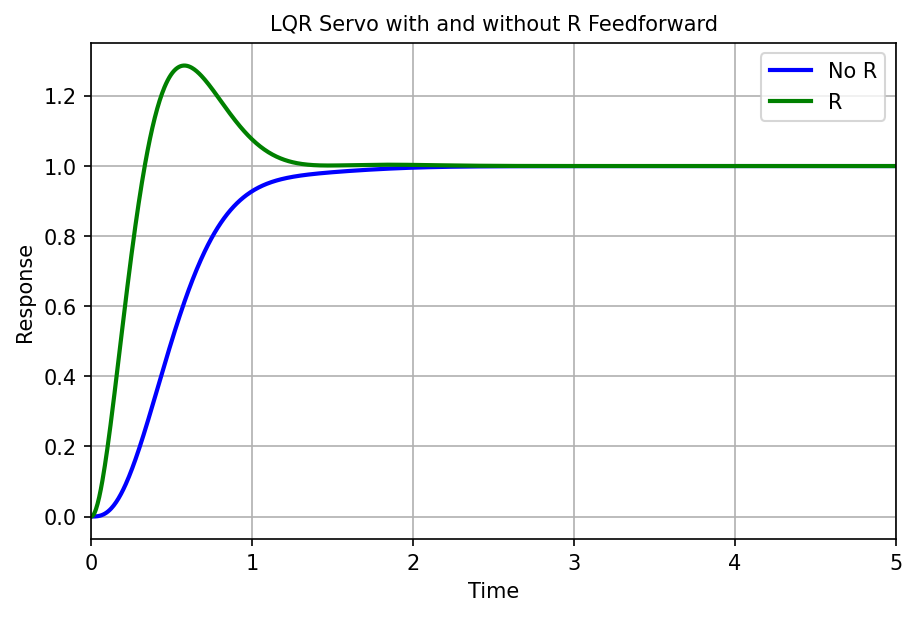

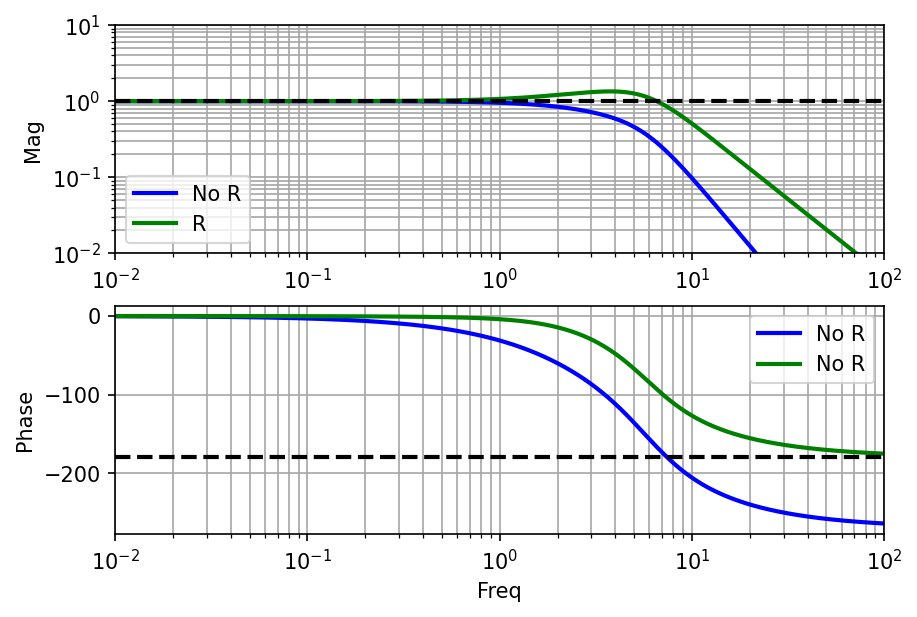

In [ ]:
import control
G = tf([1, 2],np.convolve([1, -1],[1, -1, 2]))

def LQRservo2(nom = 1):
    # convert to SS model with simpler c matrix
    a,b,c,d = control.ssdata(G)
    a = a.T;cc = b.T;b = c.T;c = cc
    cpert = c*1.01  # perturb c matrix
    
    ns = np.shape(a)[0]
    z = np.zeros((ns,1));
    Rxx = c.T@c
    Ruu = 0.001

    klqr,_,_ = lqr(a,b,Rxx,Ruu); # basic LQR gains
    klqr = np.asarray(klqr)
    Nbar = np.linalg.inv(np.dot(-c,np.dot(np.linalg.inv(a-b*klqr),b))); # design with c
    syslqr=ss(a-b*klqr,b*Nbar,cpert,0); # simulate with cpert

    Rxx1 = np.vstack((np.hstack((Rxx,z)),\
                      np.hstack((np.zeros((1,ns)),np.array([10]).reshape(1,1)))))

    R = -c.T/1.5 # choice of R discussed on 28-3
    
    # design with c
    abar = np.vstack((np.hstack((a,np.zeros((ns,1)))),np.hstack((-c,np.array([0]).reshape(1,1)))))
    bbar = np.vstack((b,np.array([0]).reshape(1,1)))
    kbar1,_,_ = lqr(abar,bbar,Rxx1,Ruu) 
    kbar1 = np.asarray(kbar1).flatten()
    K1 = kbar1[0:-1];Ki1=kbar1[-1];

    acl1 = abar - bbar*kbar1

    #implementation as on 28-4
    bcl1 = np.vstack((z,np.array([1]).reshape(1,1)))
    bcl2 = np.vstack((-b*np.dot(K1,R),np.array([1]).reshape(1,1)))
    ccl = np.hstack((c,np.array([0]).reshape(1,1)))
    dcl = 0

    Gcl1 = ss(acl1,bcl1,ccl,dcl)
    Gcl2 = ss(acl1,bcl2,ccl,dcl)
    w = logspace(-2,2,1000)
    Gcl1f = Gcl1(j*w)
    Gcl2f = Gcl2(j*w)
    
    t = np.linspace(0,5,1000)
    y1,t1 = control.matlab.step(ss(Gcl1),t)
    y2,t2 = control.matlab.step(ss(Gcl2),t)

    fig, ax = plt.subplots(1,figsize=(6, 4),dpi=150,constrained_layout = True)
    plt.plot(t1,y1,'b',label='No R')
    plt.plot(t2,y2,'g',label='R')
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('Response')
    plt.title('LQR Servo with and without R Feedforward')
    savefig("figs/LQRServo2_0.pdf", dpi=600)

    fig, ax = plt.subplots(2,1,figsize=(6, 4),dpi=150,constrained_layout = True)
    ax[0].loglog(w,np.abs(Gcl1f),'b',label='No R')
    ax[0].loglog(w,np.abs(Gcl2f),'g-',label='R')
    ax[1].semilogx(w,np.unwrap(np.angle(Gcl1f))*r2d,'b',label='No R')
    ax[1].semilogx(w,np.unwrap(np.angle(Gcl2f))*r2d,'g-',label='No R')
    ax[1].set_xlabel('Freq')
    ax[0].set_ylabel('Mag')
    ax[1].set_ylabel('Phase')
    ax[0].legend()
    ax[1].legend()
    ax[0].grid(True, which="both", ls="-",color='0.65')
    ax[1].grid(True, which="both", ls="-",color='0.65')
    ax[0].axhline(y=1,c='k',ls='--')
    ax[1].axhline(y=-180,c='k',ls='--')
    ax[0].set_ylim(1e-2,10)
    savefig("figs/LQRServo2_1.pdf", dpi=600)
    
LQRservo2(1)


# <a id='toc2_'></a>[DOFB Servo](#toc0_)

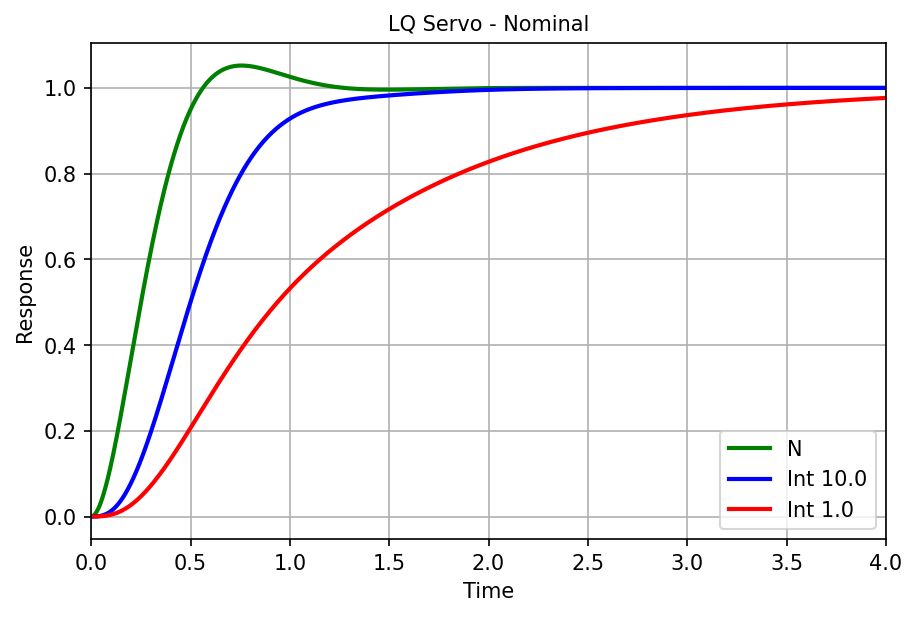

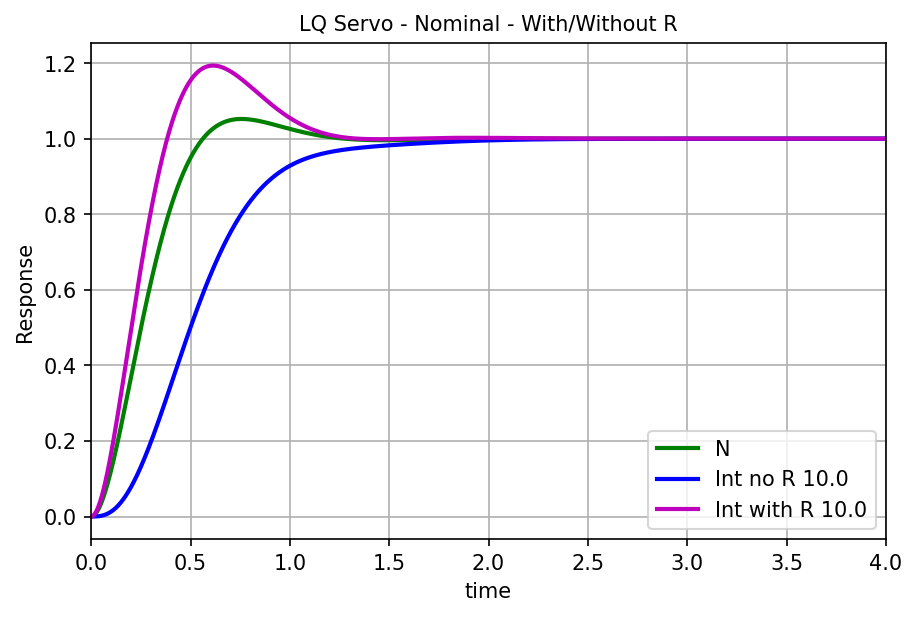

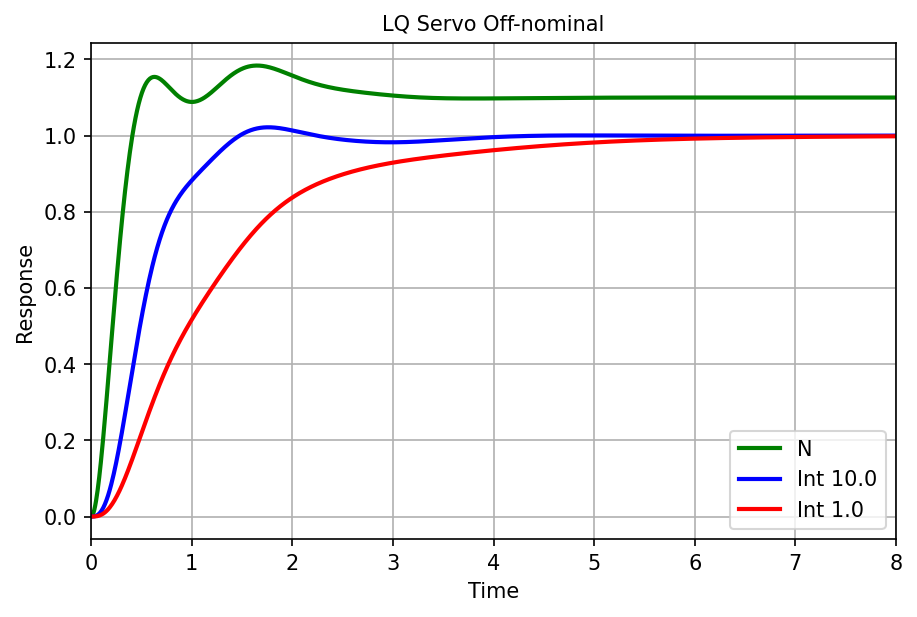

StateSpace(array([[  -5.897,    1.000,    0.000,    0.000],
       [ -95.213,  -12.251,    0.008,  100.000],
       [-173.754,  -24.503,   -1.985,  200.000],
       [   0.000,    0.000,    0.000,    0.000]]), array([[   7.897,    0.000],
       [  15.386,    0.000],
       [  22.100,    0.000],
       [  -1.000,    1.000]]), array([[ -76.827,  -12.251,   -0.992,  100.000]]), array([[   0.000,    0.000]]))

In [4]:
import control
def LQservo(G, nom = 1,file_name="figs/LQServo_", Ruu = 0.001, Rvv = 0.01, RI=1, Tf=None):
    # convert to SS model with simpler c matrix
    a,b,c,d = control.ssdata(G)
    a = a.T;cc = b.T;b = c.T;c = cc
    if nom:
        cpert = np.copy(c) # nominal case
        if Tf is None:
            Tf = 4
    else:
        cpert = 1.1*c # off-nominal case
        if Tf is None:
            Tf = 8
    
    ns = np.shape(a)[0]
    z = np.zeros((ns,1));
    Rxx = c.T@c
    
    klqr,_,_ = lqr(a,b,Rxx,Ruu); # basic LQR gains
    klqr = np.asarray(klqr).flatten()

    Nbar = np.linalg.inv(np.dot(-c,np.dot(np.linalg.inv(a-b*klqr),b))); # design with c
    syslqr=ss(a-b*klqr,b*Nbar,cpert,0); # simulate with cpert

    Rxx1 = np.vstack((np.hstack((Rxx,z)),\
                      np.hstack((np.zeros((1,ns)),np.array([10*RI]).reshape(1,1)))))
    Rxx2 = np.vstack((np.hstack((Rxx,z)),\
                      np.hstack((np.zeros((1,ns)),np.array([RI]).reshape(1,1)))))

    abar = np.vstack((np.hstack((a,np.zeros((ns,1)))),np.hstack((-c,np.array([0]).reshape(1,1)))))
    bbar = np.vstack((b,np.array([0]).reshape(1,1)))
    kbar1,_,_ = lqr(abar,bbar,Rxx1,Ruu) 
    kbar1 = np.asarray(kbar1).flatten()
    kbar2,_,_ = lqr(abar,bbar,Rxx2,Ruu) 
    kbar2 = np.asarray(kbar2).flatten()

    # use dual of LQR to design estimator
    l,_,_ = lqr(a.T,c.T,b*b.T,Rvv);
    l = np.asarray(l).flatten()
    l = l.reshape(ns,1)

    ac1 = np.vstack((np.hstack((a-np.dot(l,c)-b*kbar1[0:-1],-b*kbar1[-1])),np.hstack((z.T,np.array([0]).reshape(1,1)))))
    ac2 = np.vstack((np.hstack((a-np.dot(l,c)-b*kbar2[0:-1],-b*kbar2[-1])),np.hstack((z.T,np.array([0]).reshape(1,1)))))
    by = np.vstack((l,np.array([-1]).reshape(1,1)))
    br = np.vstack((l*0,np.array([1]).reshape(1,1)))
    cc1 = -kbar1
    cc2 = -kbar2

    # design using c and sim using cpert
    # form closed-loop dynamics
    acl1 = np.vstack((np.hstack((a,-b*kbar1)),np.hstack((by*cpert,ac1))))
    acl2 = np.vstack((np.hstack((a,-b*kbar2)),np.hstack((by*cpert,ac2))))
    bcl = np.vstack((b*0,br)) #r input matrix for basic form - changed below
    ccl = np.hstack((np.hstack((cpert,c*0)),np.array([0]).reshape(1,1)))

    Gc2=ss(ac1,np.hstack((by,br)),cc1,np.hstack((0,0)))
    
    # Nbar form
    acl3 = np.vstack((np.hstack((a,-b*klqr)),np.hstack((l*cpert,a-b*klqr-l*c))))
    bcl3 = np.vstack((b,b)) #r input matrix for basic form - changed below
    ccl3 = np.hstack((c,c*0)) # always design using nom
    Nbar = -np.linalg.inv(np.dot(ccl3,np.dot(np.linalg.inv(acl3),bcl3)))
    bcl3 = bcl3*Nbar
    ccl3 = np.hstack((cpert,c*0)) # sim using pert

    t = np.linspace(0,Tf,1000)
    [y2,t2]=control.matlab.step(ss(acl2,bcl,ccl,0),t)
    [y1,t1]=control.matlab.step(ss(acl1,bcl,ccl,0),t)
    [y3,t3]=control.matlab.step(ss(acl3,bcl3,ccl3,0),t)
    
    fig, ax = plt.subplots(1,figsize=(6, 4),dpi=150,constrained_layout = True)
    plt.plot(t3,y3,'g',label='N')
    plt.plot(t1,y1,'b',label='Int '+str(Rxx1[ns,ns]))
    plt.plot(t2,y2,'r',label='Int '+str(Rxx2[ns,ns]))
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('Response')
    if nom:
        plt.title('LQ Servo - Nominal')
        savefig(file_name+"0.pdf", dpi=600)
    else:
        plt.title('LQ Servo Off-nominal')
        savefig(file_name+"1.pdf", dpi=600)
    plt.show()
    
    if nom:
        # Use R=/= formulation
        R = -c.T/1.75;
        #print(-b*kbar1[0:-1]*R)
        fig, ax = plt.subplots(1,figsize=(6, 4),dpi=150,constrained_layout = True)
        Gcl_R = ss(acl1,np.vstack((np.vstack((np.dot(-b*kbar1[0:-1],R),np.dot(-b*kbar1[0:-1],R))),\
                                   np.array([1]).reshape(1,1))),ccl,0)
        [y4,t4]=control.matlab.step(Gcl_R,t)
        plt.plot(t3,y3,'g',label='N')
        plt.plot(t1,y1,'b',label='Int no R '+str(Rxx1[ns,ns]))
        plt.plot(t4,y4,'m-',label='Int with R '+str(Rxx1[ns,ns]))
        plt.xlabel('time')
        plt.ylabel('Response')
        plt.legend()
        plt.title('LQ Servo - Nominal - With/Without R')
        savefig(file_name+"2.pdf", dpi=600)
    
    return Gc2

G = tf([1, 2],np.convolve([1, -1],[1, -1, 2]))
LQservo(G,nom=True)
LQservo(G,nom=False)

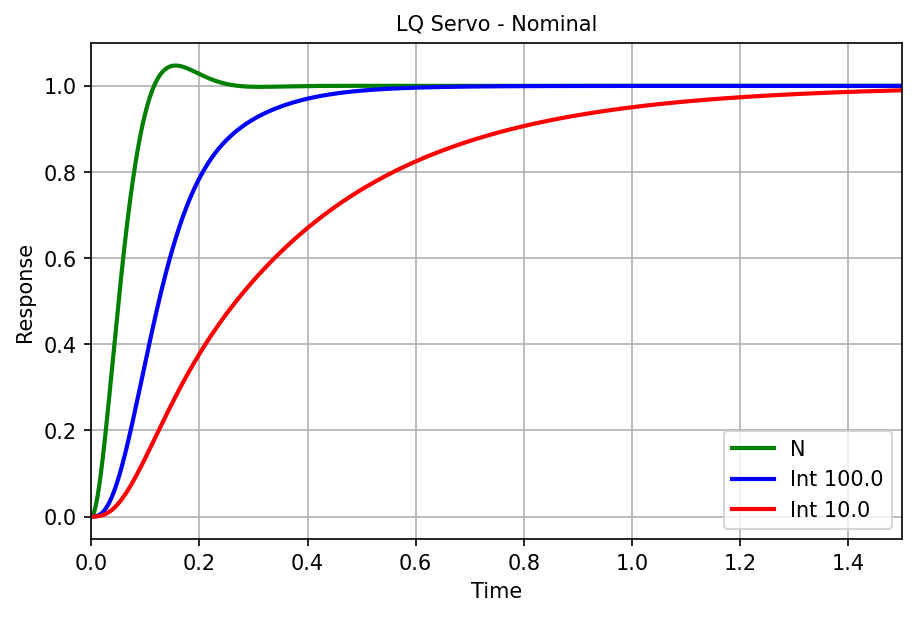

StateSpace(array([[ -13.508,    1.000,    0.000],
       [-1216.185,  -46.955,  7880.389],
       [   0.000,    0.000,    0.000]]), array([[  12.479,    0.000],
       [  90.701,    0.000],
       [  -1.000,    1.000]]), array([[ -44.236,   -1.884,  316.228]]), array([[   0.000,    0.000]]))

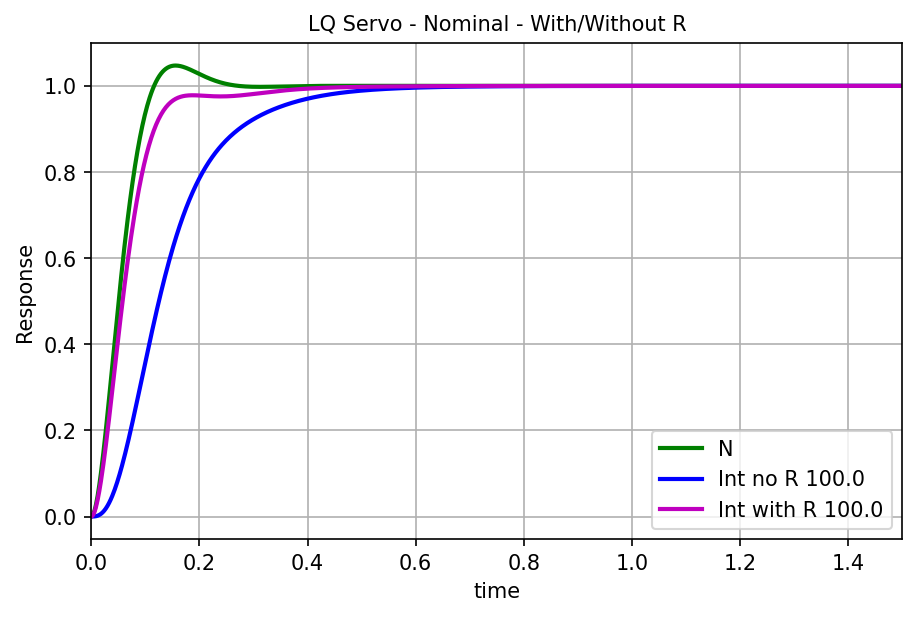

In [5]:
k,zeta,wn = np.array([   1.078,    0.107,    4.808]) # Pendulum 4

zeta_d1 = .5
zeta_d2 = .707

G = k*tf(wn**2, (1,2*zeta*wn,wn**2)) 
Gc = LQservo(G,nom=True,file_name='test',Ruu = 1e-3,Rvv = 5e-2, RI=10,Tf=1.5)
Gc